<a href="https://colab.research.google.com/github/Kibmor/pet_projects/blob/main/%D0%9F%D0%BE%D0%BC%D0%BE%D1%89%D1%8C_%D1%81%D0%B0%D0%BC%D0%BE%D0%BA%D0%B0%D1%82%D1%83_%D1%81_%D0%BC%D0%BE%D1%80%D0%BE%D0%B6%D0%B5%D0%BD%D1%8B%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gspread
from google.colab import auth
auth.authenticate_user()

In [ ]:
#!pip install pandas --upgrade
#!pip install openpyxl --upgrade --pre
#!pip install xlrd

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import random
from datetime import date, timedelta
from io import BytesIO
import requests
import seaborn as sns
import warnings
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter, FormatStrFormatter,ScalarFormatter
import matplotlib.ticker as ticker
from plotly import graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import gspread
from google.auth import default
from google.colab import data_table
import gdown
from IPython.display import Image
from IPython.display import Markdown
import nbformat
import re
warnings.filterwarnings("ignore")

Подключили библиотеки

In [ ]:
def generate_table_of_contents(notebook_path):
    notebook_url = 'https://drive.google.com/uc?id=' + notebook_path.split('/')[-2]
    gdown.download(notebook_url, 'notebook.ipynb', quiet=True)

    with open('notebook.ipynb', 'r', encoding='utf-8') as file:
        notebook = nbformat.read(file, nbformat.NO_CONVERT)

    table_of_contents = []
    heading_numbers = [0, 0, 0, 0, 0, 0]  # Начальные значения номеров для разных уровней заголовков

    for cell in notebook['cells']:
        if cell['cell_type'] == 'markdown':
            source = cell['source']
            headers = re.findall(r'^(#+)\s+(.*)$', source, flags=re.MULTILINE)

            for header in headers:
                level = len(header[0])
                title = header[1].strip()

                link = '-'.join(re.findall(r'\w+', title.lower()))
                indentation = '&nbsp;' * 2 * (level - 1)
                line_break = '\n' + '&nbsp;' * 2 * level

                heading_numbers[level - 1] += 1
                heading_number_str = '.'.join(str(num) for num in heading_numbers[:level])

                colab_link = notebook_path + f'#scrollTo={link}'
                table_of_contents.append(f'{line_break}- {heading_number_str} {title}')

    markdown_output= '\n'.join(table_of_contents)
    display(Markdown(markdown_output))

# Укажите ссылку на ваш файл на Google Диске
notebook_path = 'https://drive.google.com/file/d/1mhyZ0OgbJL06T_eU9GeFNrfMEU33g7BG/view?usp=sharing'

# Генерирование оглавления
table_of_contents = generate_table_of_contents(notebook_path)
# Отображение оглавления


&nbsp;&nbsp;&nbsp;&nbsp;- 0.1 **1. Обзор данных:**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 0.1.1 **2.1 Посчитать средний рейтинг мороженного "Самокат" за последний месяц, чтобы понять общую удовлетворенность продуктом.**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 0.1.2 **2.2 Посчитать средний рейтинг мороженного "Самокат" за последний месяц, чтобы понять общую удовлетворенность продуктом.**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 0.1.3 **2.3 Пранализировать как свззаны распределение оценок в зависимости продукта:**

&nbsp;&nbsp;&nbsp;&nbsp;- 0.2 **3. Анализ комментариев:**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 0.2.4 **3.1 Проанализировать наиболее часто встречающиеся слова и фразы в комментариях и провести общий анализ по словам**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 0.2.5 **3.2 Оценить эмоциональный окрас слов.Выделить ключевые темы и проблемы, на которые обращают внимание покупатели.**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- 0.2.6 **3.3 Оценить эмоциональный окрас комментариев**

&nbsp;&nbsp;&nbsp;&nbsp;- 0.3 **4. Формулировка гипотез:**

In [ ]:
#Функция для извлечения данных в Pandas Dataframe из Google Sheets (CSV)
def get_data(link):
  spreadsheet_id = link[link.find('d/')+2:link.find('/edit')]
  file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
  r = requests.get(file_name)
  data = pd.read_csv(BytesIO(r.content))
  return data

In [ ]:
#Функция для отображения названия таблиц
def table_name(name):
    name_length=len(name)
    print('_'*name_length)
    print(name+':')
    print('- '*int((name_length/2)))

In [ ]:
def table_print(table,name):
    table_name(name)
    display(table)

In [ ]:
#Функция для добавления таблиц в SQLite - хранилищем данных (базой данных)
con = sqlite3.connect('test.db')
def table_get_in_db(table,t_table,qty=10000):
    a=[]
    b=[]
    for x in range(0, len(table.columns.duplicated())):
        if table.columns.duplicated()[x] == True:
            a.append(x)
        if x in a:
            b.append(table.columns[x]+'_r')
        if x not in a:
            b.append(table.columns[x])
    table.columns=b
    table.to_sql(t_table, con, index=False, if_exists='replace')
    if qty!=0:
        table.name=t_table
        table_name(t_table)
        display(table.head(qty))

In [ ]:
#Функция для выполнения запросов в SQLite - хранилищем данных (базой данных)
def query(sql,t_table,qty=10):
    pd_table=pd.read_sql(sql,con = sqlite3.connect('test.db'))
    a=[]
    b=[]
    for x in range(0, len(pd_table.columns.duplicated())):
        if pd_table.columns.duplicated()[x] == True:
            a.append(x)
        if x in a:
            b.append(pd_table.columns[x]+'_r')
        if x not in a:
            b.append(pd_table.columns[x])
    pd_table.columns=b
    pd_table.to_sql(t_table, con, index=False, if_exists='replace')
    if qty!=0:
        pd_table.name=t_table
        table_name(t_table)
        display(pd_table.head(qty))
    return pd_table

In [ ]:
#Отобразим всю длину - так как строчки длинные но их немного
pd.set_option('display.max_colwidth', None)

In [ ]:
data=get_data('https://docs.google.com/spreadsheets/d/1-pZYx6duKPlLVh4fE5j7zMU870tIBwRrWM_6l_zc6_M/edit?usp=sharing')
data

,name_samokat,comment,rating
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Самое вкусное мороженое !,5
1,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",Очень вкусное ! Настоящее,5
2,"Мороженое Самокат пломбир классический, 15%, 270 г",Вкуснейшее мороженое,5
3,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г","Какая то гадость купил детям выкинули, прогорклый вкус, кароче не советую",1
4,"Мороженое Самокат пломбир, шоколадный, 15%, в контейнере, 270 г",Качественный продукт,4
...,...,...,...
3080,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г","Самое вкусное мороженое, как в детстве!",5
3081,"Мороженое Самокат эскимо, пломбир, с ванилью, в желейной оболочке из пюре манго, 15%, 80 г",Очень вкусное мороженое,5
3082,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",Очень вкусное мороженое!,4
3083,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",Вкусное мороженое 👍,5


Подключили таблицу через через google drive (google sheets) - что бы можно работать не локально, а удаленно

## **1. Обзор данных:**

###**1.1 Изучить общую структуру таблицы с отзывами: количество записей, типы данных полей, возможные пропуски.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name_samokat  3085 non-null   object
 1   comment       3085 non-null   object
 2   rating        3085 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 72.4+ KB


In [ ]:
table_name('Типы данных в колонках')
pd.DataFrame({'dtype':data.dtypes})

______________________
Типы данных в колонках:
- - - - - - - - - - - 


,dtype
name_samokat,object
comment,object
rating,int64


In [ ]:
print(f'Таблица состоит из {data.shape[0]} строк (записей) и {data.shape[1]} столбцов')

Таблица состоит из 3085 строк (записей) и 3 столбцов


In [ ]:
table_name('Количество пропусков в каждом столбце')
pd.DataFrame({'qty_of_NA':data.isna().sum()})

_____________________________________
Количество пропусков в каждом столбце:
- - - - - - - - - - - - - - - - - - 


,qty_of_NA
name_samokat,0
comment,0
rating,0


**Вывод:** Нет пропусков, проверка на дубликаты здесь не нужна

In [ ]:
table_name('Статистики по стобцу в котором есть числа - `rating`')
pd.DataFrame(data['rating'].describe().round(3))

____________________________________________________
Статистики по стобцу в котором есть числа - `rating`:
- - - - - - - - - - - - - - - - - - - - - - - - - - 


,rating
count,3085.000
mean,4.285
std,1.277
min,1.000
25%,4.000
50%,5.000
75%,5.000
max,5.000


**ВЫВОД:**

**Подключили библиотеки, затем импортировали таблицу с данными с комментариями и оценкой мороженого из Самоката.  Изучили общую информацию о датафрейме:**

**1)типы данных в колонках (наименование продукта - object;комментарий - object и rating - int),**

**2)количество строк - 3065 и столбцов - 3**

**3) пропусков не обнаружено**

**4) проаерка на дубликаты здесь не нужна**

##**2. Анализ рейтингов**

In [ ]:
count_name_samokat=data.reset_index().pivot_table(index='name_samokat',values='rating',aggfunc={'rating':['count','mean']}).sort_values(by='count',ascending=False).reset_index()
count_name_samokat['prod_id']=count_name_samokat.index+1
table_name('Количество комментариев и средняя оценка по каждому товару')


count_name_samokat['%_symbol']=count_name_samokat['name_samokat'].str.find('%')
count_name_samokat['first_right_comma_symbol']=count_name_samokat['name_samokat'].str.rfind(',')
count_name_samokat['Г_symbol']=count_name_samokat['name_samokat'].str.rfind('г')
for x in count_name_samokat.index:
  count_name_samokat.loc[x,'%_fat']=count_name_samokat.loc[x,'name_samokat'][count_name_samokat.loc[x,'%_symbol']-2:count_name_samokat.loc[x,'%_symbol']]
  count_name_samokat.loc[x,'weight']=count_name_samokat.loc[x,'name_samokat'][count_name_samokat.loc[x,'first_right_comma_symbol']+1:
                                                                                  count_name_samokat.loc[x,'Г_symbol']-1]
count_name_samokat['weight']=count_name_samokat['weight'].astype('int')
count_name_samokat.head()

__________________________________________________________
Количество комментариев и средняя оценка по каждому товару:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,name_samokat,count,mean,prod_id,%_symbol,first_right_comma_symbol,Г_symbol,%_fat,weight
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",465,4.645161,1,68,69,75,15,105
1,"Мороженое Самокат Трубочка, двухслойное, в глазури, 15%, 80 г",334,4.523952,2,54,55,60,15,80
2,"Мороженое Самокат вафельный стаканчик, пломбир, крем-брюле, 15%, 105 г",285,4.666667,3,62,63,69,15,105
3,"Десерт растительный Самокат маракуйя с манго и семенами чиа, замороженный, 70 г",234,4.551282,4,-1,73,78,0,70
4,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г",197,3.299492,5,45,46,52,10,270


In [ ]:
count_name_samokat=count_name_samokat.drop(columns=['%_symbol',	'first_right_comma_symbol',	'Г_symbol'])
count_name_samokat

,name_samokat,count,mean,prod_id,%_fat,weight
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",465,4.645161,1,15,105
1,"Мороженое Самокат Трубочка, двухслойное, в глазури, 15%, 80 г",334,4.523952,2,15,80
2,"Мороженое Самокат вафельный стаканчик, пломбир, крем-брюле, 15%, 105 г",285,4.666667,3,15,105
3,"Десерт растительный Самокат маракуйя с манго и семенами чиа, замороженный, 70 г",234,4.551282,4,0,70
4,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г",197,3.299492,5,10,270
5,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",196,4.545918,6,15,105
6,"Мороженое Самокат эскимо, пломбир с ароматом ванили, в глазури, 80 г",188,3.813830,7,0,80
7,"Мороженое Самокат эскимо, двухслойный пломбир, ваниль и шоколад, в глазури, 80 г",133,4.030075,8,0,80
8,"Мороженое Самокат пломбир классический, 15%, 270 г",132,4.530303,9,15,270
9,"Мороженое Самокат в вафельном рожке, двухслойный пломбир, со вкусом ириски и ванили, 110 г",113,3.973451,10,0,110


**Вывод:** На этой таблице видно что нет дубликатов товара с разными грамовками и процентом жирности - каждое товара является уникальным несмотря на грамовку и жирность.

**Добавили столбец `prod_id` дали каждому нименовани товару свой код:**

In [ ]:
data=data.merge(count_name_samokat).drop(columns=['count','mean'])
table_name('Добавили столбец `prod_id` дали каждому нименовани товару свой код')
data.head()

__________________________________________________________________
Добавили столбец `prod_id` дали каждому нименовани товару свой код:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,name_samokat,comment,rating,prod_id,%_fat,weight
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Самое вкусное мороженое !,5,1,15,105
1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Мороженое от Самоката лучшее в мире!!!,5,1,15,105
2,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Очень вкусное мороженое!,5,1,15,105
3,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г","Очень хорошее мороженое, без приторности",5,1,15,105
4,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Невероятно вкусное мороженое,5,1,15,105


### **2.1 Посчитать средний рейтинг мороженного "Самокат" за последний месяц, чтобы понять общую удовлетворенность продуктом.**

In [ ]:
data['rating'].sort_values().unique()

array([1, 2, 3, 4, 5])

Как видно все оценки являются целыми числами от 1 до 5- значи скорее всего можно поставить звезды в самокате или иной способ выбрать оценку заказа целым числом

In [ ]:
print(f"Среднее значение рейтинга/оценки - {data['rating'].mean().round(3)}")

Среднее значение рейтинга/оценки - 4.285


**Вывод**: Среднее значение рейтинга/оценки - 4.285

In [ ]:
print(f"Таблица и в частности колонка 'name_samokat' (нименование мороженного) состоит из {data.shape[0]} строк (записей), однако уникальных названий товаров только {data['name_samokat'].nunique()}.")

Таблица и в частности колонка 'name_samokat' (нименование мороженного) состоит из 3085 строк (записей), однако уникальных названий товаров только 27.


In [ ]:
count_name_samokat_graph=count_name_samokat.sort_values(by='count', ascending=False)[['name_samokat',	'count']]
count_name_samokat_graph['pct']=(count_name_samokat_graph['count']/count_name_samokat_graph['count'].sum(axis=0)*100).round(2)
#count_name_samokat_graph.loc['sum',:]=count_name_samokat_graph['count'].sum(axis=0)
#count_name_samokat_graph.loc['sum','name_samokat']='sum'
count_name_samokat_graph=count_name_samokat_graph.style.background_gradient(cmap='YlOrRd', axis=0, subset=['count','pct'])
count_name_samokat_graph


,name_samokat,count,pct
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",465,15.070000
1,"Мороженое Самокат Трубочка, двухслойное, в глазури, 15%, 80 г",334,10.830000
2,"Мороженое Самокат вафельный стаканчик, пломбир, крем-брюле, 15%, 105 г",285,9.240000
3,"Десерт растительный Самокат маракуйя с манго и семенами чиа, замороженный, 70 г",234,7.590000
4,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г",197,6.390000
5,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",196,6.350000
6,"Мороженое Самокат эскимо, пломбир с ароматом ванили, в глазури, 80 г",188,6.090000
7,"Мороженое Самокат эскимо, двухслойный пломбир, ваниль и шоколад, в глазури, 80 г",133,4.310000
8,"Мороженое Самокат пломбир классический, 15%, 270 г",132,4.280000
9,"Мороженое Самокат в вафельном рожке, двухслойный пломбир, со вкусом ириски и ванили, 110 г",113,3.660000


In [ ]:

# Отсортировать данные по количеству комментариев
count_name_samokat_sorted = count_name_samokat.sort_values(by='count', ascending=True)

# Создать объект графика
fig = go.Figure()

# Добавить прямоугольники на график
fig.add_trace(go.Bar(y=count_name_samokat_sorted['name_samokat'],
                     x=count_name_samokat_sorted['count'],
                     text=count_name_samokat_sorted['count'],  # Здесь указываем текст для отображения
                     textposition='outside',  # Расположение текста над прямоугольником
                     orientation='h'))

# Обновить layout графика
fig.update_layout(title='Количество комментариев по каждому товару')

# Вывести график
fig.show()


Исходя из этого можно говорит о популярности товара

###  **2.2 Посчитать средний рейтинг мороженного "Самокат" за последний месяц, чтобы понять общую удовлетворенность продуктом.**

In [ ]:
count_rating=data.reset_index().pivot_table(index='rating',values='index',aggfunc='count')
table_name('Количество комментариев мороженого по каждой оценке')
count_rating

___________________________________________________
Количество комментариев мороженого по каждой оценке:
- - - - - - - - - - - - - - - - - - - - - - - - - 


,index
rating,
1,244
2,161
3,252
4,243
5,2185


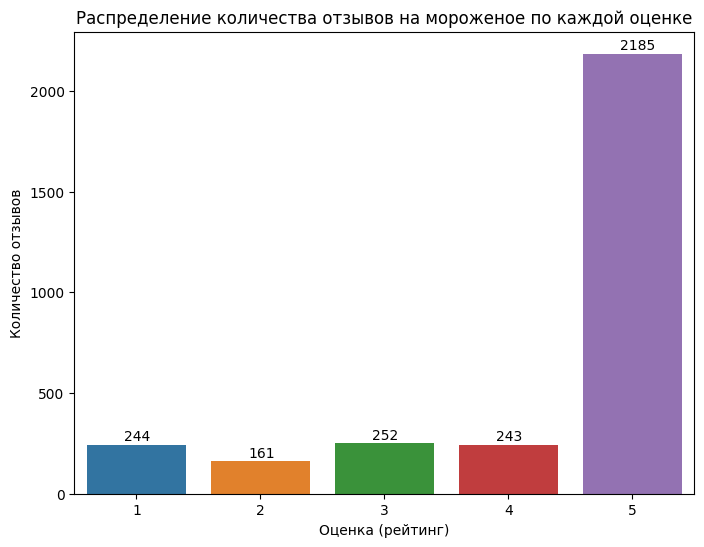

In [ ]:
plt.figure(figsize=(8, 6))
ax=sns.barplot(data=data.reset_index(), x='rating', y='index',estimator='count', ci=None)

plt.title('Распределение количества отзывов на мороженое по каждой оценке')
plt.xlabel('Оценка (рейтинг)')
plt.ylabel('Количество отзывов')
for p in ax.patches[:]:
    percentage =p.get_height()
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+0.3
    y=p.get_y()+height+20
    ax.annotate(round(percentage),(x,y))
plt.show()


In [ ]:
fig=go.Figure(go.Pie(labels=count_rating.index,values=count_rating['index']))
fig.update_layout(title='Распределение количества отзывов на мороженое по каждой оценке', # указываем заголовок графика
                  width=800, # указываем размеры графика
                  height=600,
                  annotations=[dict(x=1.12, # вручную настраиваем аннотацию легенды
                                    y=1.05,
                                    text='Оценка (рейтинг)',
                                    showarrow=False)])

In [ ]:
count_name_samokat[['prod_id','name_samokat','mean']].style.background_gradient(cmap='YlOrRd', axis=0, subset='mean')

,prod_id,name_samokat,mean
0,1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",4.645161
1,2,"Мороженое Самокат Трубочка, двухслойное, в глазури, 15%, 80 г",4.523952
2,3,"Мороженое Самокат вафельный стаканчик, пломбир, крем-брюле, 15%, 105 г",4.666667
3,4,"Десерт растительный Самокат маракуйя с манго и семенами чиа, замороженный, 70 г",4.551282
4,5,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г",3.299492
5,6,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",4.545918
6,7,"Мороженое Самокат эскимо, пломбир с ароматом ванили, в глазури, 80 г",3.813830
7,8,"Мороженое Самокат эскимо, двухслойный пломбир, ваниль и шоколад, в глазури, 80 г",4.030075
8,9,"Мороженое Самокат пломбир классический, 15%, 270 г",4.530303
9,10,"Мороженое Самокат в вафельном рожке, двухслойный пломбир, со вкусом ириски и ванили, 110 г",3.973451


In [ ]:
count_name_samokat_sorted = count_name_samokat.sort_values(by='mean', ascending=True).round(2)
fig=go.Figure()
fig.add_trace(go.Bar(y=count_name_samokat_sorted['name_samokat'],
                     x=count_name_samokat_sorted['mean'],
                     text=count_name_samokat_sorted['mean'],  # Здесь указываем текст для отображения
                     textposition='outside',  # Расположение текста над прямоугольником
                     orientation='h'))
fig.update_layout(title='Средняя оценка по каждому товару')

### **2.3 Пранализировать как свззаны распределение оценок в зависимости продукта:**

In [ ]:
name_rating_count=data.pivot_table(index=['prod_id','name_samokat'],columns='rating',values='comment',aggfunc='count',fill_value=0)
name_rating_count['sum'] = name_rating_count.sum(axis=1)
name_rating_count = name_rating_count.sort_values(by='sum', ascending=False)
name_rating_count_styled = name_rating_count.style.background_gradient(cmap='YlOrRd', axis=1, subset=name_rating_count.columns[:-1])
name_rating_count_styled = name_rating_count_styled.background_gradient(cmap='afmhot_r', axis=0, subset=['sum'])
name_rating_count_styled


,rating,1,2,3,4,5,sum
prod_id,name_samokat,,,,,,
1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",22,10,10,27,396,465
2,"Мороженое Самокат Трубочка, двухслойное, в глазури, 15%, 80 г",11,10,26,33,254,334
3,"Мороженое Самокат вафельный стаканчик, пломбир, крем-брюле, 15%, 105 г",12,3,11,16,243,285
4,"Десерт растительный Самокат маракуйя с манго и семенами чиа, замороженный, 70 г",9,7,16,16,186,234
5,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г",47,26,27,15,82,197
6,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",9,3,15,14,155,196
7,"Мороженое Самокат эскимо, пломбир с ароматом ванили, в глазури, 80 г",27,20,20,15,106,188
8,"Мороженое Самокат эскимо, двухслойный пломбир, ваниль и шоколад, в глазури, 80 г",12,13,16,10,82,133
9,"Мороженое Самокат пломбир классический, 15%, 270 г",7,5,5,9,106,132


In [ ]:
name_rating_count_pct = (name_rating_count.div(name_rating_count['sum'], axis=0) * 100).round(2)
name_rating_count_pct=name_rating_count_pct.merge(count_name_samokat,left_on=name_rating_count_pct.index.get_level_values(1),right_on='name_samokat')
name_rating_count_pct=name_rating_count_pct[['prod_id','name_samokat',1,	2,	3,	4,	5,'sum', 'count',	'mean']]
name_rating_count_pct.set_index(['prod_id','name_samokat'])

,,1,2,3,4,5,sum,count,mean
prod_id,name_samokat,,,,,,,,
1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",4.73,2.15,2.15,5.81,85.16,100.0,465,4.645161
2,"Мороженое Самокат Трубочка, двухслойное, в глазури, 15%, 80 г",3.29,2.99,7.78,9.88,76.05,100.0,334,4.523952
3,"Мороженое Самокат вафельный стаканчик, пломбир, крем-брюле, 15%, 105 г",4.21,1.05,3.86,5.61,85.26,100.0,285,4.666667
4,"Десерт растительный Самокат маракуйя с манго и семенами чиа, замороженный, 70 г",3.85,2.99,6.84,6.84,79.49,100.0,234,4.551282
5,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г",23.86,13.20,13.71,7.61,41.62,100.0,197,3.299492
6,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",4.59,1.53,7.65,7.14,79.08,100.0,196,4.545918
7,"Мороженое Самокат эскимо, пломбир с ароматом ванили, в глазури, 80 г",14.36,10.64,10.64,7.98,56.38,100.0,188,3.813830
8,"Мороженое Самокат эскимо, двухслойный пломбир, ваниль и шоколад, в глазури, 80 г",9.02,9.77,12.03,7.52,61.65,100.0,133,4.030075
9,"Мороженое Самокат пломбир классический, 15%, 270 г",5.30,3.79,3.79,6.82,80.30,100.0,132,4.530303


In [ ]:
name_rating_count_pct = (name_rating_count.div(name_rating_count['sum'], axis=0) * 100).round(2)
name_rating_count_pct=name_rating_count_pct.merge(count_name_samokat,left_on=name_rating_count_pct.index.get_level_values(1),right_on='name_samokat')
name_rating_count_pct=name_rating_count_pct[['prod_id','name_samokat',1,	2,	3,	4,	5,'sum',	'mean']]
name_rating_count_pct=name_rating_count_pct.set_index(['prod_id','name_samokat'])
name_rating_count_pct['abs_sum']=name_rating_count['sum']
name_rating_count_pct_styled = name_rating_count_pct.style.background_gradient(cmap='YlOrRd', axis=1, subset=name_rating_count.columns[:-1])
name_rating_count_pct_styled = name_rating_count_pct_styled.background_gradient(cmap='afmhot_r', axis=0, subset=['mean','abs_sum']).format('{:.2f}')
name_rating_count_pct_styled

,,1,2,3,4,5,sum,mean,abs_sum
prod_id,name_samokat,,,,,,,,
1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",4.73,2.15,2.15,5.81,85.16,100.00,4.65,465.00
2,"Мороженое Самокат Трубочка, двухслойное, в глазури, 15%, 80 г",3.29,2.99,7.78,9.88,76.05,100.00,4.52,334.00
3,"Мороженое Самокат вафельный стаканчик, пломбир, крем-брюле, 15%, 105 г",4.21,1.05,3.86,5.61,85.26,100.00,4.67,285.00
4,"Десерт растительный Самокат маракуйя с манго и семенами чиа, замороженный, 70 г",3.85,2.99,6.84,6.84,79.49,100.00,4.55,234.00
5,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г",23.86,13.20,13.71,7.61,41.62,100.00,3.30,197.00
6,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",4.59,1.53,7.65,7.14,79.08,100.00,4.55,196.00
7,"Мороженое Самокат эскимо, пломбир с ароматом ванили, в глазури, 80 г",14.36,10.64,10.64,7.98,56.38,100.00,3.81,188.00
8,"Мороженое Самокат эскимо, двухслойный пломбир, ваниль и шоколад, в глазури, 80 г",9.02,9.77,12.03,7.52,61.65,100.00,4.03,133.00
9,"Мороженое Самокат пломбир классический, 15%, 270 г",5.30,3.79,3.79,6.82,80.30,100.00,4.53,132.00


**Вывод:** стоит обратить внимание на мороженое с йогуртом и клубникой (номер 5) у нее много продаж(?отзывов?) и средння оенка одна из самых низких 3.30. Так же плохо себя показали эскимо, пломбир с ароматом ванили, в глазури(номер 7), в вафельном стаканчике, пломбир, без сахарозы, с ароматом ванили( номер 15) и в вафельном стаканчике, ванильное, без сахара, 7,5 г (номер 17)

In [ ]:
index_array=[]
for x in range(0,len(name_rating_count_pct.index)):
  index_array.append(f"{np.array(name_rating_count_pct.index.get_level_values(1)[x])} --- {np.array(name_rating_count_pct.index.get_level_values(0)[x])}")
name_rating_count_pct_graph=name_rating_count_pct.drop(columns='sum')
name_rating_count_pct_graph.index=index_array
name_rating_count_pct_graph=name_rating_count_pct_graph.sort_values(by=[5,4,3,2,1],ascending=False)
# Ваш код создания fig (оставил его как есть)
fig = px.bar(name_rating_count_pct_graph.drop(columns='abs_sum'),
             orientation='h',
             barmode='stack',
             labels={'index': 'Товары'},
             height=1000,
             width=1240)
# Настройки осей и заголовка
fig.update_layout(
    xaxis_title='Процент',
    yaxis_title='Товары',
    title='Процент оценок для каждого товара',
    yaxis=dict(showline=True, showgrid=False),
    xaxis=dict(showline=True, showgrid=True),
    bargap=0.2  # Расстояние между столбцами
)

# Получим список абсолютных сумм оценок для каждого товара
abs_sum_list = name_rating_count_pct_graph['abs_sum']
# Создаем аннотации для каждого столбца с абсолютной суммой
annotations = []
for i, abs_sum in enumerate(abs_sum_list):
    annotations.append(
        dict(
            x= 100,
            y=i,               # Координата y - номер товара (строки в данных)
            text=str(abs_sum),  # Текст аннотации - абсолютная сумма
            showarrow=False,    # Не показываем стрелку
            font=dict(size=12), # Размер шрифта
            xanchor='left',     # абсолютной суммы - слева
            yanchor='middle'    # абсолютной суммы - посередине
        )
    )
# Добавляем аннотации к графику
fig.update_layout(annotations=annotations)
# Отображаем график
fig.show()

In [ ]:
data.merge(count_name_samokat)

,name_samokat,comment,rating,prod_id,%_fat,weight,count,mean
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Самое вкусное мороженое !,5,1,15,105,465,4.645161
1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Мороженое от Самоката лучшее в мире!!!,5,1,15,105,465,4.645161
2,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Очень вкусное мороженое!,5,1,15,105,465,4.645161
3,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г","Очень хорошее мороженое, без приторности",5,1,15,105,465,4.645161
4,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Невероятно вкусное мороженое,5,1,15,105,465,4.645161
...,...,...,...,...,...,...,...,...
3080,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г","Это просто восторг, а не мороженое",5,22,15,80,9,3.333333
3081,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",Слишком сладко,3,22,15,80,9,3.333333
3082,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",Невероятное,5,22,15,80,9,3.333333
3083,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",Глазурь из маргарина,2,22,15,80,9,3.333333


**ВЫВОД:**

**Всего есть 27 уникальных товаров - товары уникальны несмотря на массу и жирность в них. Так как неудобно воспринимать такой большой текст дал код кадому уникальному товару - prod_id.**

**Средняя оценка у комментрия 4.285.**

**Самое популярное мороженное - это стандартный вафельный стаканчик с ванилью - на него приходится около 15% от все отзывов, а 6 первый по популярности мороженных занимают больше 50% от всех отзывов**

**Самая частая оценка это 5 - она занимает непропорционально большое относительное количество - около 70% всех оценок приходятся на нее. Остальные оценки распределены более равномерно. Стоит обраить внимание на мороженное с йогуртом и клубникой (номер 5) - у этого вида продукции много отзывов и плохой рейтинг - 3.30.**

## **3. Анализ комментариев:**

### **3.1 Проанализировать наиболее часто встречающиеся слова и фразы в комментариях и провести общий анализ по словам**

In [ ]:
data_3=data.copy()
data_3['comment'] = data_3['comment'].str.replace(r'[^\w\s]', ' ').str.lower()
data_3_explode=data_3.reset_index(names='comm_id')
data_3_explode['comment_explode']=data_3_explode['comment']
data_3_explode['comment_explode']=data_3_explode['comment_explode'].str.split()
data_3_explode=data_3_explode.explode('comment_explode')
data_3_explode=data_3_explode.reset_index(drop=True)
data_3_explode['comment_exp']=data_3_explode['comment_explode']
table_name('Выделим каждое слово из комментариев как отедльную строчку методом `explode`')
data_3_explode.head()

____________________________________________________________________________
Выделим каждое слово из комментариев как отедльную строчку методом `explode`:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,comm_id,name_samokat,comment,rating,prod_id,%_fat,weight,comment_explode,comment_exp
0,0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",самое вкусное мороженое,5,1,15,105,самое,самое
1,0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",самое вкусное мороженое,5,1,15,105,вкусное,вкусное
2,0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",самое вкусное мороженое,5,1,15,105,мороженое,мороженое
3,1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",мороженое от самоката лучшее в мире,5,1,15,105,мороженое,мороженое
4,1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",мороженое от самоката лучшее в мире,5,1,15,105,от,от


In [ ]:
comment_explode_count_comment= data_3_explode.pivot_table(index=['comment_exp', 'comm_id', 'comment'],
                                      values='comment_explode',
                                      aggfunc='nunique'
                                     ).sort_values(by='comm_id').reset_index()\
                                       .pivot_table(index='comment_exp',
                                                    values='comment_explode',
                                                    aggfunc='count').reset_index()\
                                       .sort_values(by='comment_explode',
                                                    ascending=False).reset_index(drop=True)

data_3_explode=data_3_explode.drop(columns='comment_exp')
comment_explode_count_comment.columns=['word','qty_nun']
table_name('Количество комментариев в которых встречаются слова')
comment_explode_count_comment.head()

___________________________________________________
Количество комментариев в которых встречаются слова:
- - - - - - - - - - - - - - - - - - - - - - - - - 


,word,qty_nun
0,вкусное,963
1,мороженое,938
2,очень,931
3,не,386
4,вкусно,337


In [ ]:
comment_explode_rating_mean=data_3_explode.pivot_table(index='comment_explode',
                                                       values=['comment','rating'],
                                                       aggfunc={'comment':'count','rating':'mean'}).reset_index().round(3)
comment_explode_rating_mean.columns=['word','qty','mean']
table_name('Количество повторенией слов для каждого слова и его средняя оценка')
comment_explode_rating_mean.head()

__________________________________________________________________
Количество повторенией слов для каждого слова и его средняя оценка:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,word,qty,mean
0,0,1,5.000
1,1,6,3.833
2,10,19,5.000
3,100,3,3.667
4,1000,2,1.000


In [ ]:
word_analysis=comment_explode_count_comment.merge(comment_explode_rating_mean).sort_values(by='qty',ascending=False).reset_index(drop=True)
table_name('Соединили две таблицы: тут есть количество комментариев и количество повторенией слов для каждого слова и его средняя оценка')
word_analysis

____________________________________________________________________________________________________________________________
Соединили две таблицы: тут есть количество комментариев и количество повторенией слов для каждого слова и его средняя оценка:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,word,qty_nun,qty,mean
0,вкусное,963,969,4.812
1,очень,931,963,4.704
2,мороженое,938,956,4.532
3,не,386,440,3.155
4,вкусно,337,339,4.676
...,...,...,...,...
2728,течь,1,1,4.000
2729,разморожена,1,1,2.000
2730,удивил,1,1,3.000
2731,удешевляет,1,1,2.000


<Figure size 640x480 with 0 Axes>

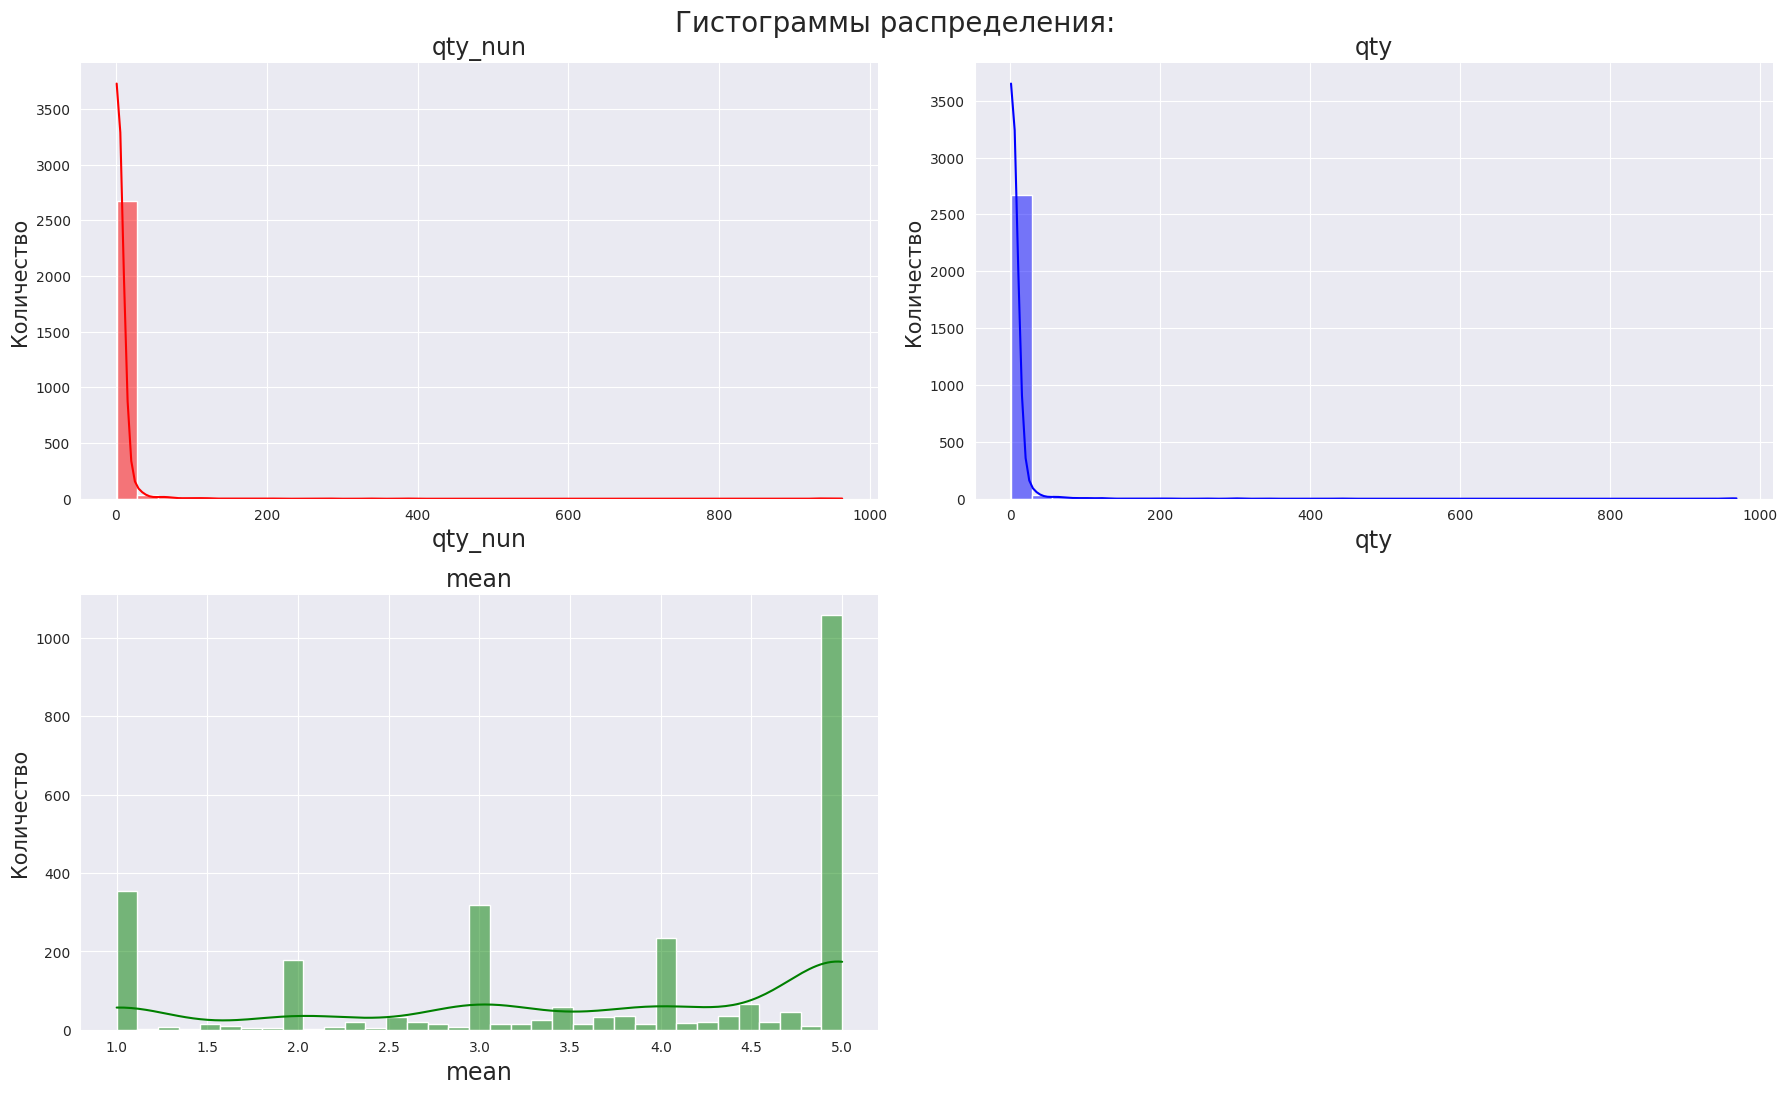

In [ ]:
sns.set_style('darkgrid')
plt.suptitle("suptitle")
fig, axs = plt.subplots(figsize=(18,16))
fig.suptitle('Гистограммы распределения:', fontsize=20)
col=['red','blue','green','purple','orange','yellow','brown','pink']
for b in word_analysis.drop(columns='word').columns:
    for n in range(0,len(word_analysis.drop(columns='word').columns)):
        if word_analysis.drop(columns='word').columns[n]==b:
            axn=n
    ax=sns.histplot(x=word_analysis.drop(columns='word')[b],bins=35, ax=plt.subplot(3,2,axn+1),color=col[axn], linewidth=1,kde=True)
    ax.set_title(b,fontsize=17)
    ax.set_xlabel(b,fontsize=17)
    ax.set_ylabel('Количество',fontsize=15)
    ax.set_ylim(-2)
plt.tight_layout()
sns.despine()

<Figure size 640x480 with 0 Axes>

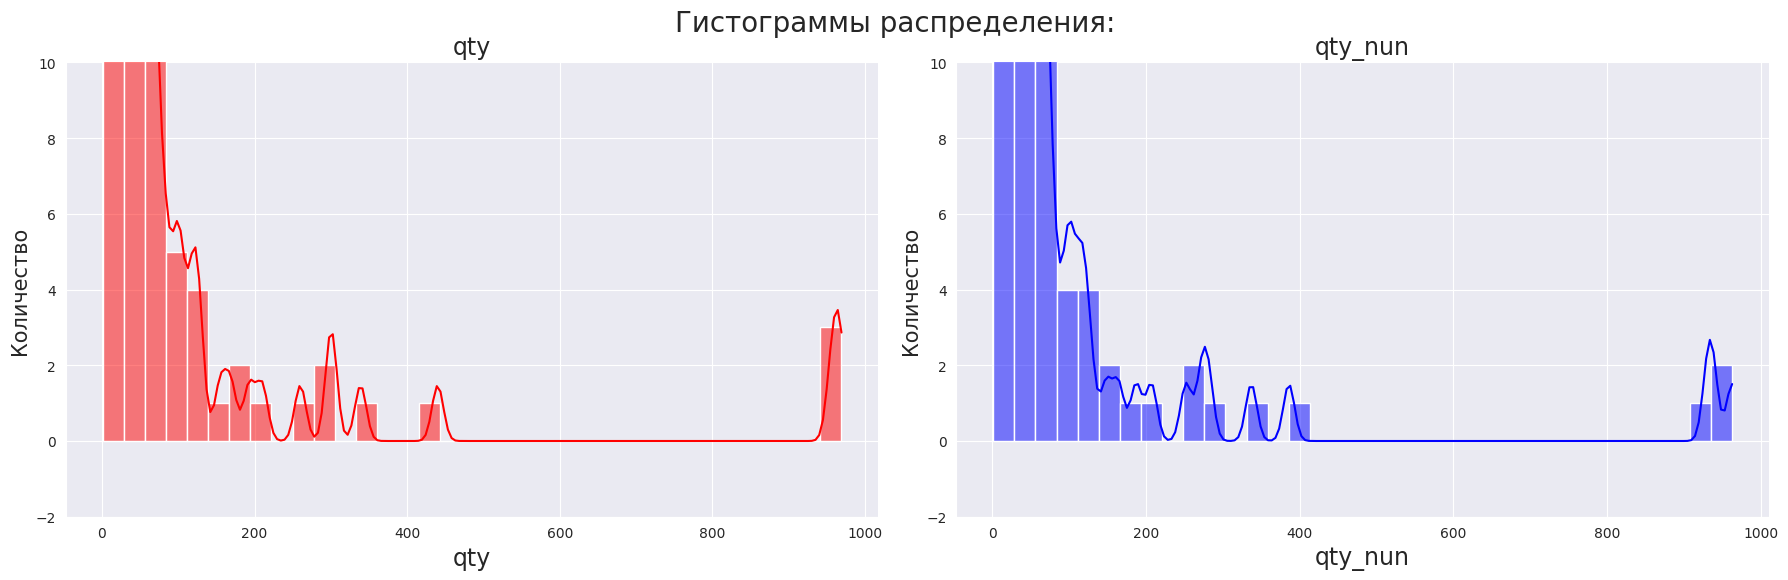

In [ ]:
sns.set_style('darkgrid')
plt.suptitle("suptitle")
fig, axs = plt.subplots(figsize=(18,16))
fig.suptitle('Гистограммы распределения:', fontsize=20)
col=['red','blue','green','purple','orange','yellow','brown','pink']
for b in word_analysis[['qty', 'qty_nun']].columns:
    for n in range(0,len(word_analysis[['qty', 'qty_nun']].columns)):
        if word_analysis[['qty', 'qty_nun']].columns[n]==b:
            axn=n
    ax=sns.histplot(x=word_analysis[['qty', 'qty_nun']][b],bins=35, ax=plt.subplot(3,2,axn+1),color=col[axn], linewidth=1,kde=True)
    ax.set_title(b,fontsize=17)
    ax.set_xlabel(b,fontsize=17)
    ax.set_ylabel('Количество',fontsize=15)
    ax.set_ylim(-2,10)
plt.tight_layout()
sns.despine()

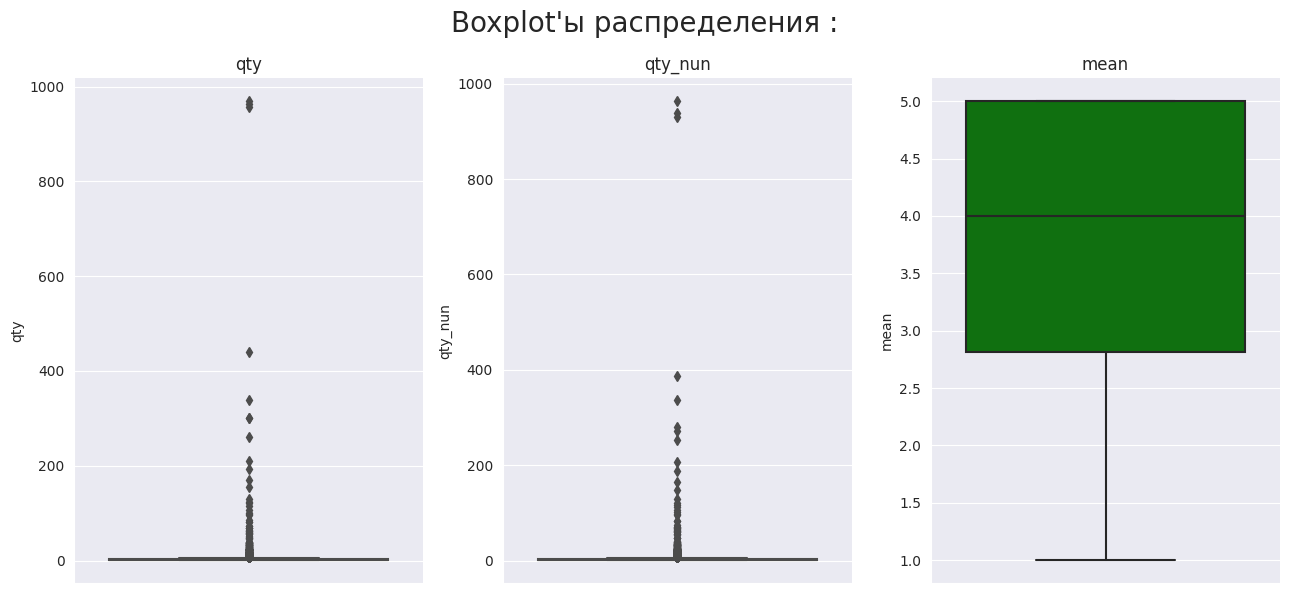

In [ ]:
def boxplots(data_x,columns):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(figsize=(13,6))

    fig.suptitle(t=f"Boxplot'ы распределения :", fontsize=20)
    col=['red','blue','green','purple','orange','yellow','brown','pink']
    num_data_boxplot=data_x[columns]
    for b in num_data_boxplot.columns:
        for n in range(0,len(num_data_boxplot.columns)):
            if num_data_boxplot.columns[n]==b:
                axn=n
        ax=sns.boxplot(y=num_data_boxplot[b], ax=plt.subplot(1,3,axn+1),color=col[axn])
        ax.set(title=b)
    plt.tight_layout()
    sns.despine()

boxplots(word_analysis, word_analysis[['qty','qty_nun','mean']].columns)


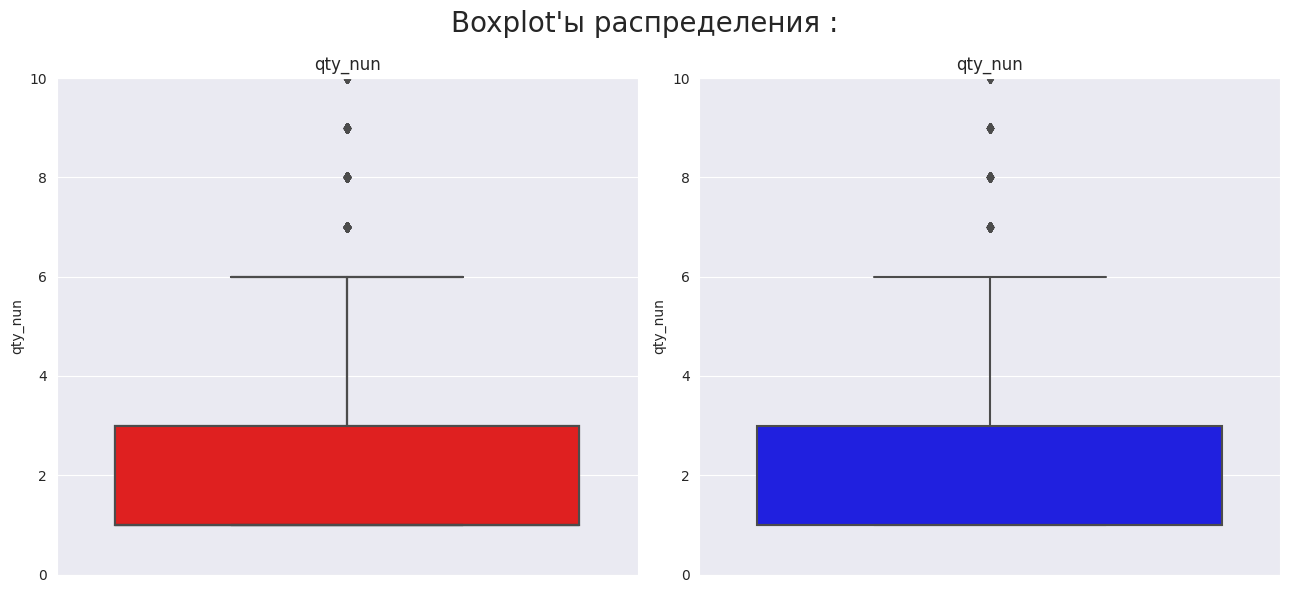

In [ ]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(figsize=(13, 6))
fig.suptitle(t="Boxplot'ы распределения :", fontsize=20)

col = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink']
num_data_boxplot = word_analysis[['qty', 'qty_nun']]

for b in num_data_boxplot.columns:
    for n in range(0, len(num_data_boxplot.columns)):
        if num_data_boxplot.columns[n] == b:
            axn = n
        ax = sns.boxplot(y=num_data_boxplot[b], ax=plt.subplot(1, 2, axn + 1), color=col[axn])
        ax.set(title=b)
        ax.set_ylim(0, 10)

plt.tight_layout()


In [ ]:
word_analysis['cumsum_qty_left']=np.cumsum(word_analysis['qty'])
word_analysis['cumsum_qty_right']=np.cumsum(word_analysis.sort_values(by='qty').reset_index(drop=True)['qty']).sort_values(ascending=False).reset_index(drop=True)
from scipy.stats import percentileofscore
for x in word_analysis.index:
  word_analysis.loc[x,'percentile_rank_left'] = percentileofscore(word_analysis['qty'], word_analysis.loc[x,'qty'])
word_analysis['percentile_rank_right'] = 100-word_analysis['percentile_rank_left']
word_analysis

,word,qty_nun,qty,mean,cumsum_qty_left,cumsum_qty_right,percentile_rank_left,percentile_rank_right
0,вкусное,963,969,4.812,969,15315,100.000000,0.000000
1,очень,931,963,4.704,1932,14346,99.963410,0.036590
2,мороженое,938,956,4.532,2888,13383,99.926820,0.073180
3,не,386,440,3.155,3328,12427,99.890231,0.109769
4,вкусно,337,339,4.676,3667,11987,99.853641,0.146359
...,...,...,...,...,...,...,...,...
2728,течь,1,1,4.000,15311,5,30.552506,69.447494
2729,разморожена,1,1,2.000,15312,4,30.552506,69.447494
2730,удивил,1,1,3.000,15313,3,30.552506,69.447494
2731,удешевляет,1,1,2.000,15314,2,30.552506,69.447494


In [ ]:
pct_rank_word=word_analysis.pivot_table(index=['qty','percentile_rank_left']).reset_index()[['qty','percentile_rank_left']]
pct_rank_word['diff_%']=pct_rank_word['percentile_rank_left']-pct_rank_word['percentile_rank_left']\
                                                            .shift(1,fill_value=0)
pct_rank_word.head(10)

,qty,percentile_rank_left,diff_%
0,1,30.552506,30.552506
1,2,67.892426,37.339920
2,3,78.064398,10.171972
3,4,83.260154,5.195756
4,5,86.114160,2.854007
5,6,87.907062,1.792902
6,7,89.498719,1.591658
7,8,90.944018,1.445298
8,9,91.968533,1.024515
9,10,92.608855,0.640322


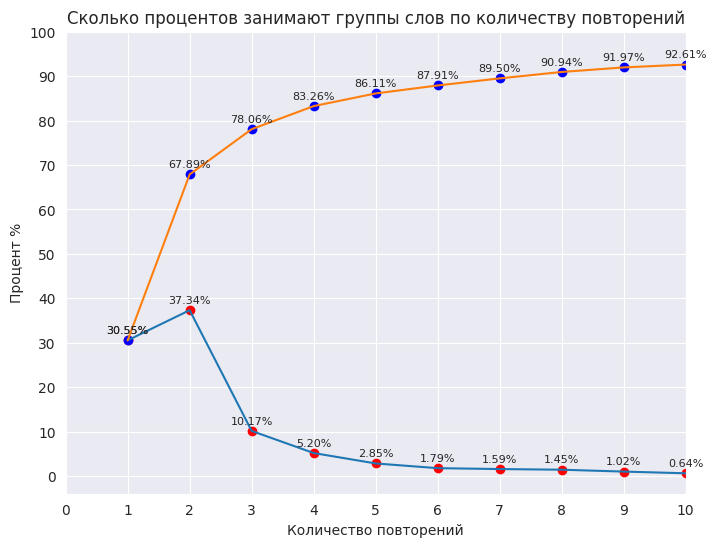

In [ ]:
fig, axs = plt.subplots(figsize=(8, 6))
ax1 = sns.lineplot(data=pct_rank_word.head(10), x='qty', y='diff_%')
ax2 = sns.lineplot(data=pct_rank_word.head(10), x='qty', y='percentile_rank_left')
axs.set_xlim(0, 10)

# Добавление точек
ax1.scatter(data=pct_rank_word.head(10), x='qty', y='diff_%', color='red')
ax2.scatter(data=pct_rank_word.head(10), x='qty', y='percentile_rank_left', color='blue')

# Добавление подписей к точкам
for index, row in pct_rank_word.head(10).iterrows():
    ax1.annotate(f"{row['diff_%']:.2f}%", (row['qty'], row['diff_%']), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    ax2.annotate(f"{row['percentile_rank_left']:.2f}%", (row['qty'], row['percentile_rank_left']), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

# Настройка подписей на оси x через каждое значение 1
xticks_values = list(range(0, 11, 1))
axs.set_xticks(xticks_values)

# Настройка подписей на оси y через каждое значение 5
yticks_values = list(range(0, 101, 10))
axs.set_yticks(yticks_values)

plt.title('Сколько процентов занимают группы слов по количеству повторений')
plt.xlabel('Количество повторений')
plt.ylabel('Процент %')
plt.show()


In [ ]:
for x in pct_rank_word.head(10).index:
  print(f"* Слова которые повторяются {pct_rank_word.loc[x,'qty']} раз, занимают {pct_rank_word.loc[x,'diff_%'].round(2)}% от суммы всех слов.")

* Слова которые повторяются 1 раз, занимают 30.55% от суммы всех слов.
* Слова которые повторяются 2 раз, занимают 37.34% от суммы всех слов.
* Слова которые повторяются 3 раз, занимают 10.17% от суммы всех слов.
* Слова которые повторяются 4 раз, занимают 5.2% от суммы всех слов.
* Слова которые повторяются 5 раз, занимают 2.85% от суммы всех слов.
* Слова которые повторяются 6 раз, занимают 1.79% от суммы всех слов.
* Слова которые повторяются 7 раз, занимают 1.59% от суммы всех слов.
* Слова которые повторяются 8 раз, занимают 1.45% от суммы всех слов.
* Слова которые повторяются 9 раз, занимают 1.02% от суммы всех слов.
* Слова которые повторяются 10 раз, занимают 0.64% от суммы всех слов.


**Вывод:**

Процент слов которые повторяются меньше 10 раз - 92%

Процент слов которые повторяются меньше 2 раз - 70%

In [ ]:
word_analysis.sort_values(by='qty',ascending=False).head(50)

,word,qty_nun,qty,mean,cumsum_qty_left,cumsum_qty_right,percentile_rank_left,percentile_rank_right
0,вкусное,963,969,4.812,969,15315,100.000000,0.000000
1,очень,931,963,4.704,1932,14346,99.963410,0.036590
2,мороженое,938,956,4.532,2888,13383,99.926820,0.073180
3,не,386,440,3.155,3328,12427,99.890231,0.109769
4,вкусно,337,339,4.676,3667,11987,99.853641,0.146359
5,и,272,301,3.834,3968,11648,99.817051,0.182949
6,в,281,300,3.987,4268,11347,99.780461,0.219539
7,вкус,252,260,3.831,4528,11047,99.743871,0.256129
8,самое,207,210,4.929,4738,10787,99.707281,0.292719
9,как,187,193,3.891,4931,10577,99.670692,0.329308


**Вывод:** Если проанализировать 50 самых популярных слов то можно понять что клиентов в больше степени волнует в доставке мороженого по популярности: вкус, тип, ассоциации, сравнение, оценка, благодарности.

In [ ]:
word_analysis[(word_analysis['mean']<2)*(word_analysis['qty']>=10)]

,word,qty_nun,qty,mean,cumsum_qty_left,cumsum_qty_right,percentile_rank_left,percentile_rank_right
60,растаявшее,30,30,1.867,8156,7189,97.768020,2.231980
91,растаяло,22,22,1.909,8943,6394,96.542261,3.457739
140,полностью,14,14,1.571,9831,5498,94.767655,5.232345
153,ужасное,13,13,1.154,10008,5320,94.310282,5.689718
174,горькое,12,12,1.583,10269,5058,93.779729,6.220271
192,пришло,11,11,1.818,10470,4856,93.175997,6.824003
195,ужасный,11,11,1.364,10503,4823,93.175997,6.824003
201,пластилин,10,10,1.600,10563,4762,92.608855,7.391145


### **3.2 Оценить эмоциональный окрас слов.Выделить ключевые темы и проблемы, на которые обращают внимание покупатели.**

**Можно было использовать библиотеку TextBlob однако я разработал свой метод**

In [ ]:
table_name('Выведем все слова и то как часто они встречаются')
word_analysis

________________________________________________
Выведем все слова и то как часто они встречаются:
- - - - - - - - - - - - - - - - - - - - - - - - 


,word,qty_nun,qty,mean,cumsum_qty_left,cumsum_qty_right,percentile_rank_left,percentile_rank_right
0,вкусное,963,969,4.812,969,15315,100.000000,0.000000
1,очень,931,963,4.704,1932,14346,99.963410,0.036590
2,мороженое,938,956,4.532,2888,13383,99.926820,0.073180
3,не,386,440,3.155,3328,12427,99.890231,0.109769
4,вкусно,337,339,4.676,3667,11987,99.853641,0.146359
...,...,...,...,...,...,...,...,...
2728,течь,1,1,4.000,15311,5,30.552506,69.447494
2729,разморожена,1,1,2.000,15312,4,30.552506,69.447494
2730,удивил,1,1,3.000,15313,3,30.552506,69.447494
2731,удешевляет,1,1,2.000,15314,2,30.552506,69.447494


In [ ]:
table_name('Выведем слова которые встречаются больше 10 раз')
top_words_more_10=word_analysis[word_analysis['qty']>=10]
top_words_more_10

_______________________________________________
Выведем слова которые встречаются больше 10 раз:
- - - - - - - - - - - - - - - - - - - - - - - 


,word,qty_nun,qty,mean,cumsum_qty_left,cumsum_qty_right,percentile_rank_left,percentile_rank_right
0,вкусное,963,969,4.812,969,15315,100.000000,0.000000
1,очень,931,963,4.704,1932,14346,99.963410,0.036590
2,мороженое,938,956,4.532,2888,13383,99.926820,0.073180
3,не,386,440,3.155,3328,12427,99.890231,0.109769
4,вкусно,337,339,4.676,3667,11987,99.853641,0.146359
...,...,...,...,...,...,...,...,...
204,лёд,10,10,3.200,10593,4732,92.608855,7.391145
205,сожалению,10,10,2.100,10603,4722,92.608855,7.391145
206,глазури,10,10,3.900,10613,4712,92.608855,7.391145
207,крошки,10,10,3.300,10623,4702,92.608855,7.391145


**Думаю тут будет более удобна ручная работы - я буд ставить +, -, 1 или 0 в зависимости от положительного, усилительного, отрицательно или нейтрального смысла слова (слова всего 200 - не так много).**

Выгрузим таблицу в gsheets

In [ ]:
creds, _ = default()
gc = gspread.authorize(creds)
def googlesheets(link, my_df):
  worksheet = gc.open_by_url(link).sheet1
  worksheet.update([my_df.columns.values.tolist()] + my_df.values.tolist())
googlesheets('https://docs.google.com/spreadsheets/d/10FXoPoJGLJc2WkaQWdU7nzuqOTgNB0uNDBkBwfHXFB4/edit?usp=drive_link', top_words_more_10)

**Тут выгруженная таблиц откопировалась мной что бы дальше она не менялась - и уже в этой таблице (что ниже) я в ручную определял оценку слова:**

https://docs.google.com/spreadsheets/d/1mGy8wZDU9Cl0IYhBOmGUPNDHJVYprcTQwWk779hlH8k/edit?usp=sharing

In [ ]:
top_words_more_10=get_data('https://docs.google.com/spreadsheets/d/1mGy8wZDU9Cl0IYhBOmGUPNDHJVYprcTQwWk779hlH8k/edit?usp=sharing')
top_words_more_10=top_words_more_10.rename(columns = {'index':'word'})
top_words_more_10.head()

,word,qty,good/bad
0,вкусное,969,(+)
1,очень,963,1
2,мороженое,956,0
3,не,440,-
4,вкусно,339,(+)


In [ ]:
top_words_more_10.loc[top_words_more_10['good/bad']=='(+)','good/bad']='+'
top_words_more_10.loc[top_words_more_10['good/bad']=='-','good/bad']='-'
top_words_more_10.loc[top_words_more_10['good/bad']=='0','good/bad']='0'
top_words_more_10.loc[top_words_more_10['good/bad']=='1','good/bad']='1'
top_words_more_10.loc[top_words_more_10['word']=='не','good/bad']='~'
top_words_more_10=top_words_more_10[top_words_more_10['good/bad']!=0]
table_name('Таблица с популярными (те что встречаются больше 10 раз)+ добавлен доп. смысл для "не"-`~`')
top_words_more_10=top_words_more_10.merge(word_analysis,how='left')[['word'	,'qty',	'good/bad'	,	'mean'	]]
top_words_more_10

__________________________________________________________________________________________
Таблица с популярными (те что встречаются больше 10 раз)+ добавлен доп. смысл для "не"-`~`:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,word,qty,good/bad,mean
0,вкусное,969,+,4.812
1,очень,963,1,4.704
2,мороженое,956,0,4.532
3,не,440,~,3.155
4,вкусно,339,+,4.676
...,...,...,...,...
197,лёд,10,0,3.200
198,несколько,10,0,2.700
199,тех,10,0,4.600
200,глазури,10,0,3.900


In [ ]:
no_pd=pd.DataFrame()
for x in top_words_more_10[top_words_more_10['good/bad']=='+'].index:
  no_pd.loc[x,'word']='не '+top_words_more_10.loc[x,'word']
  no_pd.loc[x,'qty']=(data['comment']+' ').sum().count(f"не {top_words_more_10.loc[top_words_more_10.index==x,'word'].item()}")
  no_pd.loc[x,'good/bad']='-'
no_pd=no_pd[no_pd['qty']!=0]
for i in no_pd.index:
    no_pd.loc[i, 'mean'] = data.loc[data['comment'].apply(lambda x: x.find(no_pd.loc[i, 'word']) != -1), 'rating'].mean().round()
no_pd_concat_top_words_more_10=pd.concat([no_pd,top_words_more_10[top_words_more_10['good/bad']=='-']]).sort_values(by='qty',ascending=False)
no_pd_concat_top_words_more_10.head()

,word,qty,good/bad,mean
43,нет,36.0,-,3.750
54,растаявшее,30.0,-,1.867
62,мало,27.0,-,3.593
22,не понравилось,22.0,-,3.000
86,совсем,22.0,-,2.500


In [ ]:
table_name('Представлен список самых проблемных слов')
no_pd_concat_top_words_more_10[(no_pd_concat_top_words_more_10['qty']>=10)*(no_pd_concat_top_words_more_10['mean']<3.5)]

________________________________________
Представлен список самых проблемных слов:
- - - - - - - - - - - - - - - - - - - - 


,word,qty,good/bad,mean
54,растаявшее,30.0,-,1.867
22,не понравилось,22.0,-,3.000
86,совсем,22.0,-,2.500
92,растаяло,22.0,-,1.909
89,горчит,22.0,-,2.591
107,странный,18.0,-,2.556
113,растаявшим,18.0,-,2.333
4,не вкусно,16.0,-,2.000
128,любителя,15.0,-,3.333
152,ужасное,13.0,-,1.154


**Вывод:** Самые частые жалобы на вкус(не вкусное, горчит, приторное), на то что мороженное растаявшее, на то что мороженого мало, на то что тает

### **3.3 Оценить эмоциональный окрас комментариев**

In [ ]:
data_1=data_3.copy()
data_1.shape[0]

3085

In [ ]:
data_1['code_com']=''
for i in data_1.index:
  for x in data_1.loc[i,'comment'].split():
    try:
      data_1.loc[i,'code_com']=data_1.loc[i,'code_com']+top_words_more_10.loc[top_words_more_10['word']==x,'good/bad'].item()
    except:
      data_1.loc[i,'code_com']=data_1.loc[i,'code_com']+'0'
table_name('В изначальную таблицу добавлено кодирование слова на положительную/отрицательную и др. оценку')
data_1

_____________________________________________________________________________________________
В изначальную таблицу добавлено кодирование слова на положительную/отрицательную и др. оценку:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,name_samokat,comment,rating,prod_id,%_fat,weight,code_com
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",самое вкусное мороженое,5,1,15,105,1+0
1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",мороженое от самоката лучшее в мире,5,1,15,105,000+00
2,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",очень вкусное мороженое,5,1,15,105,1+0
3,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",очень хорошее мороженое без приторности,5,1,15,105,1+000
4,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",невероятно вкусное мороженое,5,1,15,105,1+0
...,...,...,...,...,...,...,...
3080,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",это просто восторг а не мороженое,5,22,15,80,01+0~0
3081,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",слишком сладко,3,22,15,80,10
3082,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",невероятное,5,22,15,80,0
3083,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",глазурь из маргарина,2,22,15,80,000


In [ ]:
data_2=data_1.copy()
data_2['comment'] = data_2['comment'].str.replace(r'[^\w\s]', ' ').str.lower()
data_2['code_com_2']=data_2['code_com']

In [ ]:
defenition_list=[]
coding_forms_list=[]
score_change_list=[]
def dict_update(defenition,coding_forms,score_change):
  defenition_list.append(defenition)
  coding_forms_list.append(coding_forms)
  score_change_list.append(score_change)

dict_update('усиление/не/положительный смысл = усиление отриц. смысла',       '1~+','-3')
dict_update('не/усиление/положительный смысл = отриц. смысл',                 '~1+','-1')
dict_update('не/положительный смысл = отриц. смысл',                          '~+' ,'-1')
dict_update('усиление/положительный смысл = усиление положительного смысла',  '1+' ,'3' )
dict_update('усиление/отрц. смысл = усиление отриц. смысла',                  '1-' ,'-3')
dict_update('положительный смысл',                                            '+'  ,'1' )
dict_update('отрц. смысл',                                                    '-'  ,'-1')
#dict_update('0','')
my_dict = pd.DataFrame({'defenition':defenition_list,'coding_forms':coding_forms_list,'score_change':score_change_list})
table_name('Совокупности кодификаций слов, их объяснение и оценка их значения')
my_dict

_________________________________________________________________
Совокупности кодификаций слов, их объяснение и оценка их значения:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,defenition,coding_forms,score_change
0,усиление/не/положительный смысл = усиление отриц. смысла,1~+,-3
1,не/усиление/положительный смысл = отриц. смысл,~1+,-1
2,не/положительный смысл = отриц. смысл,~+,-1
3,усиление/положительный смысл = усиление положительного смысла,1+,3
4,усиление/отрц. смысл = усиление отриц. смысла,1-,-3
5,положительный смысл,+,1
6,отрц. смысл,-,-1


In [ ]:
data_2['score']=0
for x in my_dict.index:
  data_2.loc[data_2['code_com_2'].str.find(my_dict.loc[x,'coding_forms'])!=-1,'score']=data_2.loc[data_2['code_com_2'].str.find(my_dict.loc[x,'coding_forms'])!=-1,'score']+int(my_dict.loc[x,'score_change'])
  data_2['code_com_2']=data_2['code_com_2'].str.replace(my_dict.loc[x,'coding_forms'], '',regex=False)
data_2

,name_samokat,comment,rating,prod_id,%_fat,weight,code_com,code_com_2,score
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",самое вкусное мороженое,5,1,15,105,1+0,0,3
1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",мороженое от самоката лучшее в мире,5,1,15,105,000+00,00000,1
2,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",очень вкусное мороженое,5,1,15,105,1+0,0,3
3,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",очень хорошее мороженое без приторности,5,1,15,105,1+000,000,3
4,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",невероятно вкусное мороженое,5,1,15,105,1+0,0,3
...,...,...,...,...,...,...,...,...,...
3080,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",это просто восторг а не мороженое,5,22,15,80,01+0~0,00~0,3
3081,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",слишком сладко,3,22,15,80,10,10,0
3082,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",невероятное,5,22,15,80,0,0,0
3083,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",глазурь из маргарина,2,22,15,80,000,000,0


In [ ]:
print(data_2[data_2['code_com']==data_2['code_com_2']].shape[0])
print(data_2[data_2['code_com']!=data_2['code_com_2']].shape[0])

785
2300


2300 комментария, которые я смог закодировать, из 3085 это неплохой результат

In [ ]:
data_2[['rating','score']].corr()

,rating,score
rating,1.000000,0.558266
score,0.558266,1.000000


**Вывод**: Корреляция между оценкой коментария (по моим метрикам) и оценкой из приложения - 0.56 - это средний результат. Что говорит о наличии срене-слабой свзяи между настроением в комментарии и оценкой из приложения  или о несовершенстве алгоритмического метода (скорее о втором). Здесь можно внедрять нейросеть которая будет и обучаться на базе комментариев. Она сможет лучше определять какие слова, словосочетания предложения, символы и смайлки больше влияют на оценку.

In [ ]:
 data.join(data_2[data_2.columns.difference(data.columns)], how='left').merge(count_name_samokat)


,name_samokat,comment,rating,prod_id,%_fat,weight,code_com,code_com_2,score,count,mean
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Самое вкусное мороженое !,5,1,15,105,1+0,0,3,465,4.645161
1,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Мороженое от Самоката лучшее в мире!!!,5,1,15,105,000+00,00000,1,465,4.645161
2,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Очень вкусное мороженое!,5,1,15,105,1+0,0,3,465,4.645161
3,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г","Очень хорошее мороженое, без приторности",5,1,15,105,1+000,000,3,465,4.645161
4,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",Невероятно вкусное мороженое,5,1,15,105,1+0,0,3,465,4.645161
...,...,...,...,...,...,...,...,...,...,...,...
3080,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г","Это просто восторг, а не мороженое",5,22,15,80,01+0~0,00~0,3,9,3.333333
3081,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",Слишком сладко,3,22,15,80,10,10,0,9,3.333333
3082,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",Невероятное,5,22,15,80,0,0,0,9,3.333333
3083,"Мороженое Самокат эскимо, пломбир, с ароматом ванили, карамель и арахис, в глазури, 15%, 80 г",Глазурь из маргарина,2,22,15,80,000,000,0,9,3.333333


**Получим таблицу с комментариями перевденными через фунцкию =GOOGLETRANSLATE(текст; [язык_оригинала]; [язык_перевода]) (((GOOGLETRANSLATE(comment; "ru"; "en"))) в Google Shets**

In [ ]:
data_en=get_data('https://docs.google.com/spreadsheets/d/10mp3_biqZSbcJtJq0ne5XQD0PUwHv9XBUB38PxmqCaw/edit?usp=sharing')
data_en.head()

,name_samokat,comment,rating
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",The most delicious ice cream!,5
1,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",Very delicious ! The present,5
2,"Мороженое Самокат пломбир классический, 15%, 270 г",Delicious ice cream,5
3,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г","Some kind of muck bought children threw out, a bad taste, I do not advise",1
4,"Мороженое Самокат пломбир, шоколадный, 15%, в контейнере, 270 г",Quality product,4


In [ ]:
# Функция для определения тональности текста с помощью TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity
# Применение функции к столбцу 'Текст' в DataFrame
data_en['tone_score'] = data_en['comment'].apply(get_sentiment)
data_en

,name_samokat,comment,rating,tone_score
0,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г",The most delicious ice cream!,5,0.75
1,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",Very delicious ! The present,5,0.50
2,"Мороженое Самокат пломбир классический, 15%, 270 г",Delicious ice cream,5,1.00
3,"Мороженое Самокат с йогуртом, с клубникой, 10%, 270 г","Some kind of muck bought children threw out, a bad taste, I do not advise",1,-0.05
4,"Мороженое Самокат пломбир, шоколадный, 15%, в контейнере, 270 г",Quality product,4,0.00
...,...,...,...,...
3080,"Мороженое Самокат вафельный стаканчик, пломбир с ароматом ванили, 15%, 105 г","The most delicious ice cream, as in childhood!",5,0.75
3081,"Мороженое Самокат эскимо, пломбир, с ванилью, в желейной оболочке из пюре манго, 15%, 80 г",Very tasty ice cream,5,0.20
3082,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",Very tasty ice cream!,4,0.25
3083,"Мороженое Самокат вафельный стаканчик, шоколадный пломбир, 15%, 105 г",Tasty ice cream ♥,5,1.00


In [ ]:
data.join(data_2[data_2.columns.difference(data.columns)], how='left').merge(count_name_samokat)[['rating','count','mean','%_fat','weight','score']]

,rating,count,mean,%_fat,weight,score
0,5,465,4.645161,15,105,3
1,5,465,4.645161,15,105,1
2,5,465,4.645161,15,105,3
3,5,465,4.645161,15,105,3
4,5,465,4.645161,15,105,3
...,...,...,...,...,...,...
3080,5,9,3.333333,15,80,3
3081,3,9,3.333333,15,80,0
3082,5,9,3.333333,15,80,0
3083,2,9,3.333333,15,80,0


In [ ]:
correlation= data.join(data_2[data_2.columns.difference(data.columns)], how='left').merge(count_name_samokat).join(data_en['tone_score'])[['rating','count','mean','%_fat','weight','score','tone_score']]
correlation

,rating,count,mean,%_fat,weight,score,tone_score
0,5,465,4.645161,15,105,3,0.75
1,5,465,4.645161,15,105,1,0.50
2,5,465,4.645161,15,105,3,1.00
3,5,465,4.645161,15,105,3,-0.05
4,5,465,4.645161,15,105,3,0.00
...,...,...,...,...,...,...,...
3080,5,9,3.333333,15,80,3,0.75
3081,3,9,3.333333,15,80,0,0.20
3082,5,9,3.333333,15,80,0,0.25
3083,2,9,3.333333,15,80,0,1.00


In [ ]:
vivod=correlation.corr()
for x in vivod.index:
  for y in vivod.columns:
    if x==y:
      vivod.loc[x,y]=''
    elif abs(vivod.loc[x,y])>=0.67:
      vivod.loc[x,y]='Сильная связь'
    elif 0.67>abs(vivod.loc[x,y])>=0.45:
      vivod.loc[x,y]='Средняя связь'
    elif abs(vivod.loc[x,y])<0.45:
      vivod.loc[x,y]='Слабая связь'

vivod

,rating,count,mean,weight,score,tone_score
rating,,Слабая связь,Слабая связь,Слабая связь,Средняя связь,Слабая связь
count,Слабая связь,,Средняя связь,Слабая связь,Слабая связь,Слабая связь
mean,Слабая связь,Средняя связь,,Слабая связь,Слабая связь,Слабая связь
weight,Слабая связь,Слабая связь,Слабая связь,,Слабая связь,Слабая связь
score,Средняя связь,Слабая связь,Слабая связь,Слабая связь,,Слабая связь
tone_score,Слабая связь,Слабая связь,Слабая связь,Слабая связь,Слабая связь,


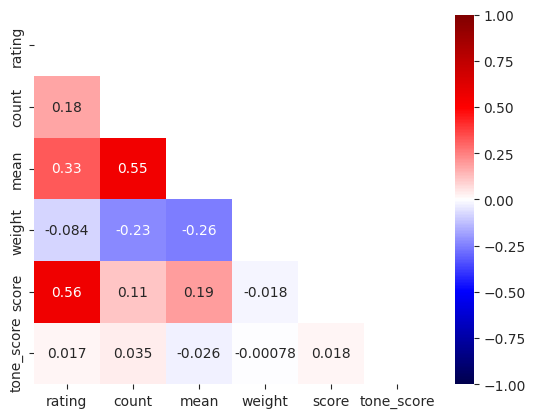

<Figure size 2000x1000 with 0 Axes>

In [ ]:
mask=np.zeros_like(correlation.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style('ticks')
sns.heatmap(correlation.corr(),mask=mask,vmin=-1,vmax=1,cmap='seismic',square=False,annot=True)
plt.figure(figsize=(20, 10))
plt.show()

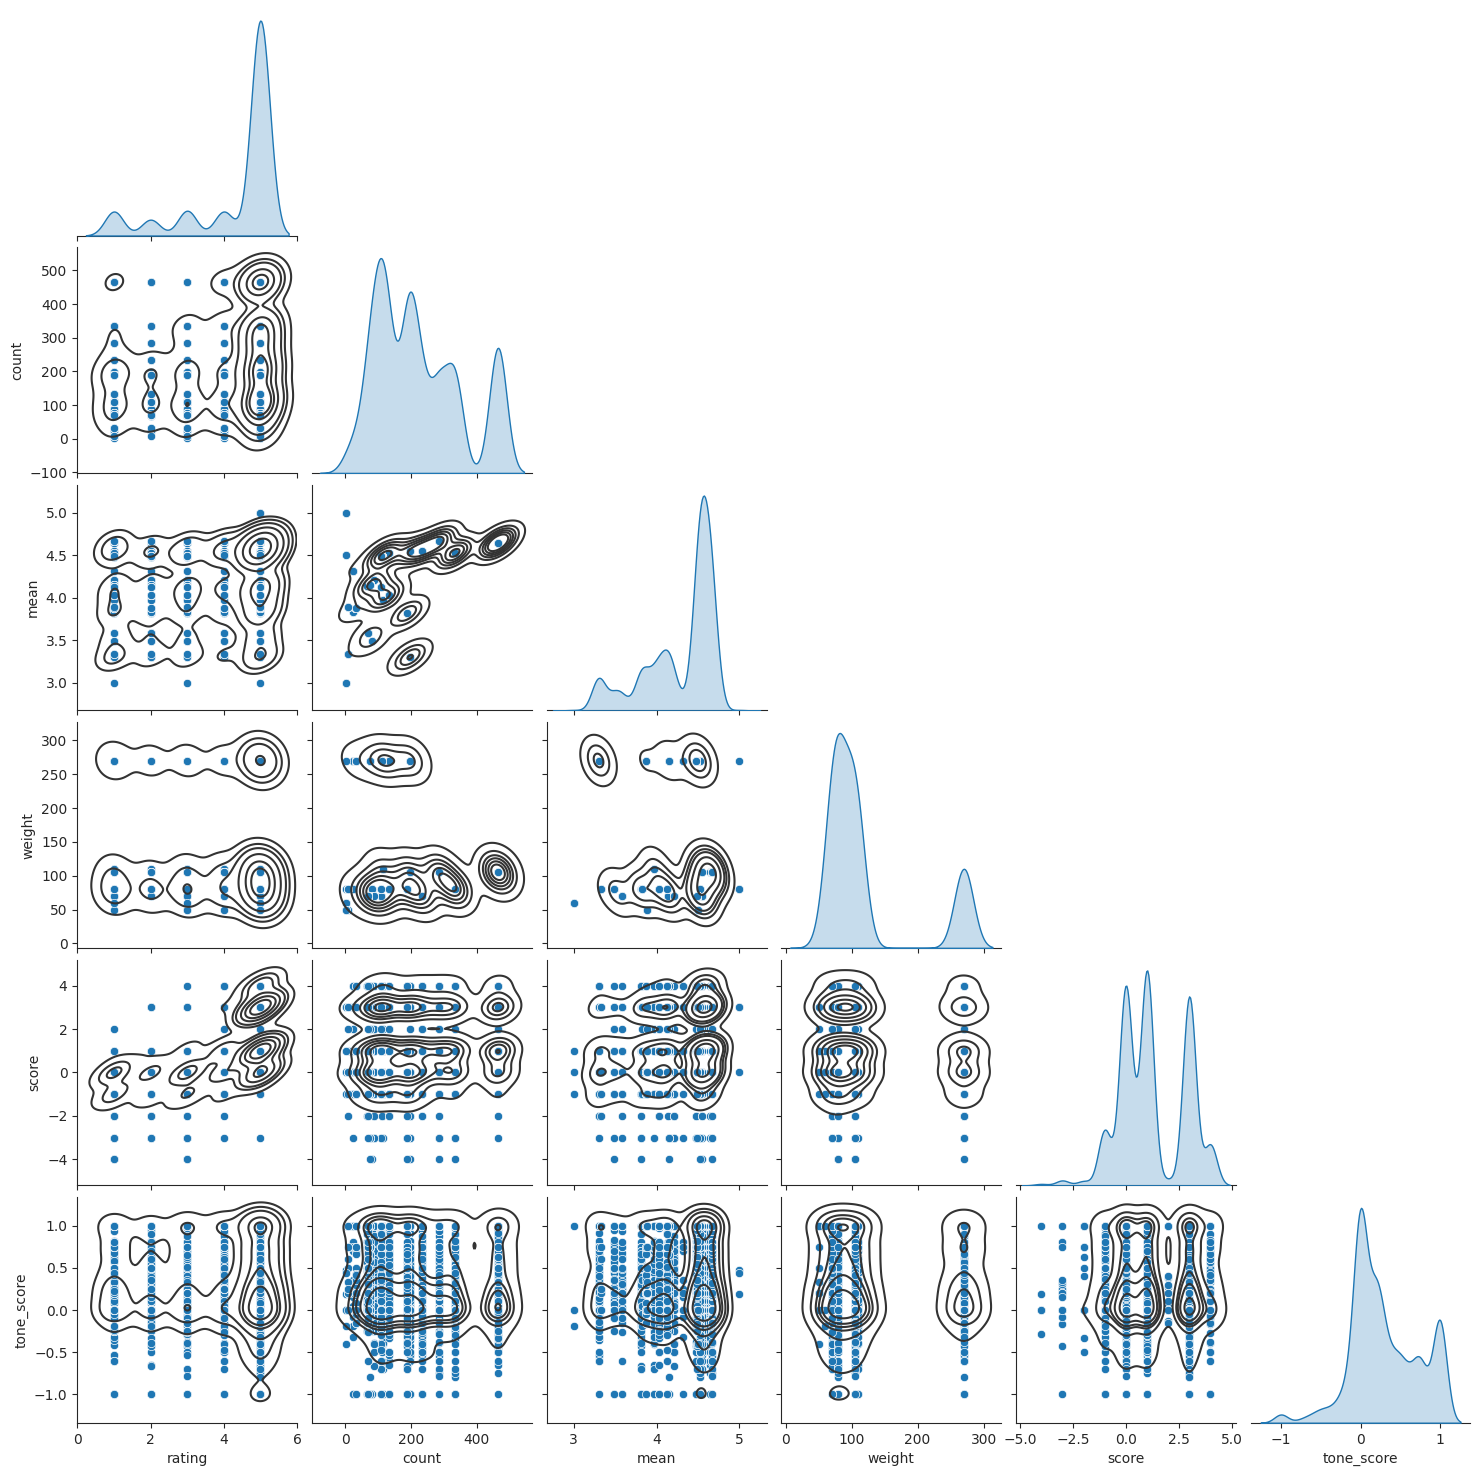

<Figure size 2000x1000 with 0 Axes>

In [ ]:
g = sns.pairplot(data=correlation, diag_kind='kde',corner=True)
g.map_lower(sns.kdeplot, levels=7, color=".2")

# Увеличим размер графика для лучшей видимости
plt.figure(figsize=(20, 10))

# Выводим график
plt.show()


**Вывод:** Рейтинг не связан с количеством комментариев о товаре

**ВЫВОД:**

**1) В комментариях к товару очень неравномерно распределны. Распределние похоже на ветвь гиперболы и совпадает с законом Ципфа. Более 50% всех слов встречаются лишь единожды или дважды. Процент слов которые повторяются меньше 10 раз - 92%, а меньше 2 раз - 70%.**

**2) При расставлении оценок 200 самым популярным словам я ставил +, -, 1 или 0 в зависимости от положительного, усилительного, отрицательно или нейтрального смысла слова. Как вяснилось самые частые жалобы на то что мороженное растаявшее или на вкусове качества: не вкусное (оценка), горчит(горькое), приторное. Далее в сами комментарии внедрялась система кодирования**

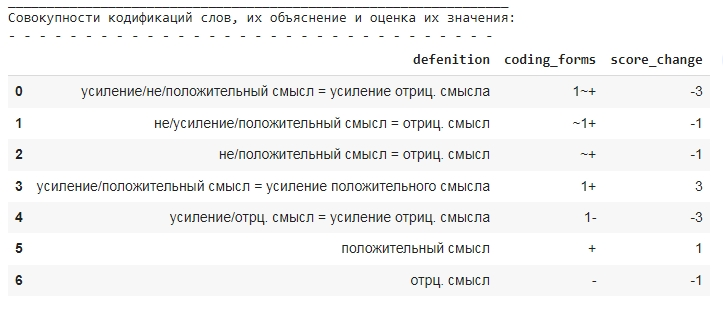

**3) Изначально у всех комментариев 0 значение положительности/отрицательности - далее при внедрении кодификации - комментарии получают оценку в зависимости от тона (эту систему можно доработать с нескольких сторон или внедрить нейросеть).**

**4) Мне удалось закодировать (придать эмоцианальную окраску в числах) для 2300 коментариев из 3085. Корреляци между эмоциональной закодированной оценкой комментария и оценкой (рейтингом) проставленной пользователем равна 0.55 что является неплохим результатом оценки системы кодирования.**

## **4. Формулировка гипотез:**

На основе проведенного анализа данных и результатов эмоциональной кодировки комментариев, можно сформулировать несколько гипотез по улучшению опыта покупателей мороженного "Самокат":

a) Улучшение качества продукции: Повышение качества мороженного, особенно у популярных видов, таких как мороженное с йогуртом и клубникой, может привлечь больше довольных клиентов и улучшить рейтинг продукции.

b) Улучшение качества доставки: Внедрение улучшенных методов доставки мороженного поможет предотвратить случаи растаявшего продукта и повысить удовлетворенность клиентов.

c) Внедрение программы лояльности: Внедрение программы лояльности с бонусами и скидками для постоянных клиентов может стимулировать повторные покупки и удержание клиентов.

##**5.Проверка гипотез:**

Для каждой гипотезы необходимо определить методы проверки и валидации.

a) Для проверки гипотезы об улучшении качества продукции, можно провести исследование мнения клиентов после внесения изменений в рецептуру или производственные процессы. Анализировать отзывы и рейтинг продукции до и после улучшений.

b) Для проверки гипотезы об улучшении качества доставки, можно провести опрос клиентов, учитывая их мнения и оценки доставки, а также анализировать изменения в оценках и отзывах после внедрения улучшений.

c) Для проверки гипотезы о внедрении программы лояльности, можно следить за частотой повторных покупок после внедрения программы и сравнивать ее с предыдущими данными.

##**6. Сводный отчет:**

После проведения анализа, проверки гипотез и внесения улучшений, подготовьте сводный отчет с описанием выполненных шагов, полученных результатов и предложений по улучшению опыта покупателей, на основе анализа данных о качестве продукции, доставке  и т.д. Включите в отчет графики, диаграммы, статистические данные и обоснования для предложенных мероприятий.

Предложите конкретные действия и мероприятия на основе результатов анализа, которые могут быть применены компанией "Самокат" для улучшения качества продукции, доставки и удержания клиентов.

Важно также обратить внимание на то, что дополнительные исследования и сбор дополнительных данных могут помочь углубить анализ и подтвердить гипотезы. Если вам доступны дополнительные данные о клиентах, их предпочтениях, покупательских привычках и т. д., вы можете использовать их для более детального анализа и формулирования более точных гипотез.